## neural_network

In [71]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from datetime import datetime
import pandas_profiling as ppf
from tensorboardX import SummaryWriter
writer=SummaryWriter(logdir='./neuron_summary')

ALL=pd.read_csv(r'./data/created_data/logistic_final.csv').reset_index(drop=True).set_index('ID')

# making all variables categorical
for col in ALL.columns:
    ALL[col] = ALL[col].astype('category')
    
txt=ALL[['行业','企业类型','控制人类型','区域']]

#categorical embedding for columns having more than two values?
embedded_cols = {n: len(col.cat.categories) for n,col in txt.items()}

embedded_col_names = embedded_cols.keys()
# print(embedded_col_names)
n=len(ALL.columns) - len(embedded_cols) -1 #number of numerical columns,still exists flag

embedding_sizes = [(n_categories, min(50, (n_categories+1)//2)) for _,n_categories in embedded_cols.items()]


y=ALL['flag'].to_numpy()
train_X,val_X, train_y, val_y = train_test_split(ALL.drop(columns='flag'),y, test_size=0.30, random_state=0)

class CompanyDataset(Dataset):
    def __init__(self, X, Y, embedded_col_names):
        X = X.copy()
        self.X1 = X.loc[:,embedded_col_names].copy().values.astype(np.int64) #categorical columnss
        self.X2 = X.drop(columns=embedded_col_names).copy().values.astype(np.float32) #numerical columns
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]
    

train_ds = CompanyDataset(train_X, train_y,embedded_col_names)
valid_ds = CompanyDataset(val_X,val_y,embedded_col_names)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    
device = get_default_device()

class FlagModel(nn.Module):  #分为两部分categorical 和 continuous
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined  
        
        self.n_emb, self.n_cont = n_emb, n_cont
        
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)  #线性层输入： 输出：(200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 2)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)
        
        self.emb_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, x_cat, x_cont):  #描述了一个前向计算图
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]   #(embeddings): ModuleList(
#                                                                                  (0): Embedding(992, 50)
#                                                                                  (1): Embedding(51, 26)
#   )
        x = torch.cat(x, 1)
        x = self.emb_drop(x)  #把categorical  drop_out
        
        x2 = self.bn1(x_cont)   #把continuous标准化
        
        x = torch.cat([x, x2], 1)  #把categorical 和 continuous 合并
        x = F.relu(self.lin1(x))  #线性层并激活
        x = self.drops(x)        #drop_out
        
        x = self.bn2(x)         #标准化
        x = F.relu(self.lin2(x)) #线性层并激活
        x = self.drops(x)        #drop_out
        x = self.bn3(x)          #标准化
        x = self.lin3(x)         #线性层

#         x=torch.sigmoid(x)
        return x

model = FlagModel(embedding_sizes, n)
to_device(model, device)

def get_optimizer(model, lr = 0.001, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters()) #filter过滤序列，留下True
    optim = torch_optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

def train_model(model, optim, train_dl,i):
    model.train()
    total = 0
    sum_loss = 0
    for x1, x2, y in train_dl:
        batch = y.shape[0]
        output = model(x1, x2)
        y=y.long()
        loss = F.cross_entropy(output, y)   
        optim.zero_grad()
        loss.backward()
        optim.step()
        total += batch
        sum_loss += batch*(loss.item())
    writer.add_scalar('train_loss',sum_loss/total,i)
    return sum_loss/total

def val_loss(model, valid_dl,i):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x1, x2, y in valid_dl:
        current_batch_size = y.shape[0]
        out = model(x1, x2)
        y=y.long()
        loss = F.cross_entropy(out, y)
        sum_loss += current_batch_size*(loss.item())
        total += current_batch_size
        pred = torch.max(out, 1)[1]
        correct += (pred == y).float().sum().item()
#         correct = torch.mean((pred == y).float())
    writer.add_scalar('valid_loss',sum_loss/total,i)
    writer.add_scalar('valid_acc',correct/total,i)
    print("valid loss %f and accuracy %f " % (sum_loss/total, correct/total))
    return sum_loss/total, correct/total

def train_loop(model, epochs, lr=0.01, wd=0.0):
    optim = get_optimizer(model, lr = lr, wd = wd)
    for i in range(epochs): 
        loss = train_model(model, optim, train_dl,i)
        print("training loss: ", loss)
        _,acc=val_loss(model, valid_dl,i)
        if acc>0.99:
            break
    return 

batch_size = 1000
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True)


train_dl = DeviceDataLoader(train_dl,device)
valid_dl = DeviceDataLoader(valid_dl,device)

train_loop(model, epochs=100, lr=0.0001, wd=0.05)

training loss:  0.7068792891517659
valid loss 0.608746 and accuracy 0.691037 
training loss:  0.637253312872068
valid loss 0.551645 and accuracy 0.762353 
training loss:  0.5877290233821679
valid loss 0.515017 and accuracy 0.806833 
training loss:  0.5503205781523824
valid loss 0.482117 and accuracy 0.835838 
training loss:  0.5242459343740933
valid loss 0.453430 and accuracy 0.857218 
training loss:  0.4987636158784129
valid loss 0.428824 and accuracy 0.871197 
training loss:  0.4734555294940732
valid loss 0.402577 and accuracy 0.883905 
training loss:  0.452534045662417
valid loss 0.377309 and accuracy 0.893698 
training loss:  0.43210244406037357
valid loss 0.350419 and accuracy 0.898856 
training loss:  0.4122562869471336
valid loss 0.328435 and accuracy 0.907453 
training loss:  0.3925605701907481
valid loss 0.309350 and accuracy 0.911938 
training loss:  0.3750597458548822
valid loss 0.291359 and accuracy 0.918965 
training loss:  0.3592551149301367
valid loss 0.271680 and accura

## logistic regression

In [72]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pandas_profiling as ppf
# from tensorboardX import SummaryWriter
from sklearn.model_selection import train_test_split
writer=SummaryWriter(logdir='./logistic_summary')

ALL=pd.read_csv(r'./data/created_data/logistic_final.csv').reset_index(drop=True).set_index('ID')

y=ALL['flag']
train_X,val_X, train_y, val_y = train_test_split(ALL.drop(columns='flag'),y, test_size=0.30, random_state=0)

class LR(nn.Module):
    def __init__(self):
        super(LR,self).__init__()
        self.fc=nn.Linear(27,2) # 由于16个维度已经固定了，所以这里写16
    def forward(self,x):
        x=self.fc(x)
        out=torch.sigmoid(x)
        return out


def test(pred,lab):
    t=pred.max(-1)[1]==lab
    return torch.mean(t.float())


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()

# 网络模型实例化
net=LR()
to_device(net, device)
# 使用CrossEntropyLoss损失
criterion=nn.CrossEntropyLoss() # BCEloss待测
# 优化器
optm=torch.optim.Adamax(net.parameters(),lr=0.01) 
# 训练1500次
epochs=10000


for i in range(epochs):
#      指定模型为训练模式，计算梯度
    net.train()
#      输入值都需要转化成torch的Tensor
    x=to_device(torch.from_numpy(train_X.values).float(),device)
    y=to_device(torch.from_numpy(train_y.values).long(),device)
#     输入数据
    y_hat=net(x)
#     计算损失
    loss=criterion(y_hat,y) 
#     前一步的损失清零
    optm.zero_grad() 
#     反向传播 
    loss.backward() 
#     更新参数
    optm.step() 
#     writer.add_scalar('tra_loss',loss,i)

    if True:
#     if (i+1)%200 ==0 : # 这里我们每100次输出相关的信息
#         指定模型为计算模式
        net.eval()
        test_in=to_device(torch.from_numpy(val_X.values).float(),device)
        test_l=to_device(torch.from_numpy(val_y.values).long(),device)
        test_out=net(test_in)
#          使用我们的测试函数计算准确率
        accu=test(test_out,test_l)
        writer.add_scalar('tes_loss',loss.item(),i)
        writer.add_scalar('tes_acc',accu,i)
        print("Epoch:{},Loss:{:.4f},Accuracy：{:.4f}".format(i+1,loss.item(),accu))    

Epoch:1,Loss:0.6456,Accuracy：0.6480
Epoch:2,Loss:0.6428,Accuracy：0.6472
Epoch:3,Loss:0.6409,Accuracy：0.6467
Epoch:4,Loss:0.6393,Accuracy：0.6461
Epoch:5,Loss:0.6379,Accuracy：0.6460
Epoch:6,Loss:0.6365,Accuracy：0.6466
Epoch:7,Loss:0.6350,Accuracy：0.6473
Epoch:8,Loss:0.6336,Accuracy：0.6485
Epoch:9,Loss:0.6322,Accuracy：0.6496
Epoch:10,Loss:0.6308,Accuracy：0.6511
Epoch:11,Loss:0.6296,Accuracy：0.6531
Epoch:12,Loss:0.6284,Accuracy：0.6547
Epoch:13,Loss:0.6272,Accuracy：0.6557
Epoch:14,Loss:0.6261,Accuracy：0.6578
Epoch:15,Loss:0.6250,Accuracy：0.6587
Epoch:16,Loss:0.6238,Accuracy：0.6599
Epoch:17,Loss:0.6226,Accuracy：0.6605
Epoch:18,Loss:0.6214,Accuracy：0.6608
Epoch:19,Loss:0.6203,Accuracy：0.6616
Epoch:20,Loss:0.6191,Accuracy：0.6625
Epoch:21,Loss:0.6180,Accuracy：0.6638
Epoch:22,Loss:0.6169,Accuracy：0.6652
Epoch:23,Loss:0.6158,Accuracy：0.6678
Epoch:24,Loss:0.6147,Accuracy：0.6700
Epoch:25,Loss:0.6136,Accuracy：0.6728
Epoch:26,Loss:0.6125,Accuracy：0.6751
Epoch:27,Loss:0.6114,Accuracy：0.6766
Epoch:28,L

Epoch:223,Loss:0.5145,Accuracy：0.8386
Epoch:224,Loss:0.5143,Accuracy：0.8391
Epoch:225,Loss:0.5141,Accuracy：0.8392
Epoch:226,Loss:0.5138,Accuracy：0.8394
Epoch:227,Loss:0.5136,Accuracy：0.8399
Epoch:228,Loss:0.5134,Accuracy：0.8401
Epoch:229,Loss:0.5132,Accuracy：0.8403
Epoch:230,Loss:0.5129,Accuracy：0.8408
Epoch:231,Loss:0.5127,Accuracy：0.8410
Epoch:232,Loss:0.5125,Accuracy：0.8413
Epoch:233,Loss:0.5123,Accuracy：0.8414
Epoch:234,Loss:0.5120,Accuracy：0.8416
Epoch:235,Loss:0.5118,Accuracy：0.8420
Epoch:236,Loss:0.5116,Accuracy：0.8424
Epoch:237,Loss:0.5114,Accuracy：0.8428
Epoch:238,Loss:0.5112,Accuracy：0.8432
Epoch:239,Loss:0.5110,Accuracy：0.8436
Epoch:240,Loss:0.5107,Accuracy：0.8441
Epoch:241,Loss:0.5105,Accuracy：0.8447
Epoch:242,Loss:0.5103,Accuracy：0.8450
Epoch:243,Loss:0.5101,Accuracy：0.8453
Epoch:244,Loss:0.5099,Accuracy：0.8456
Epoch:245,Loss:0.5097,Accuracy：0.8458
Epoch:246,Loss:0.5095,Accuracy：0.8460
Epoch:247,Loss:0.5093,Accuracy：0.8464
Epoch:248,Loss:0.5091,Accuracy：0.8465
Epoch:249,Lo

Epoch:444,Loss:0.4795,Accuracy：0.8874
Epoch:445,Loss:0.4794,Accuracy：0.8876
Epoch:446,Loss:0.4793,Accuracy：0.8877
Epoch:447,Loss:0.4791,Accuracy：0.8880
Epoch:448,Loss:0.4790,Accuracy：0.8880
Epoch:449,Loss:0.4789,Accuracy：0.8882
Epoch:450,Loss:0.4788,Accuracy：0.8883
Epoch:451,Loss:0.4787,Accuracy：0.8885
Epoch:452,Loss:0.4786,Accuracy：0.8887
Epoch:453,Loss:0.4785,Accuracy：0.8887
Epoch:454,Loss:0.4784,Accuracy：0.8889
Epoch:455,Loss:0.4783,Accuracy：0.8891
Epoch:456,Loss:0.4781,Accuracy：0.8893
Epoch:457,Loss:0.4780,Accuracy：0.8897
Epoch:458,Loss:0.4779,Accuracy：0.8897
Epoch:459,Loss:0.4778,Accuracy：0.8899
Epoch:460,Loss:0.4777,Accuracy：0.8900
Epoch:461,Loss:0.4776,Accuracy：0.8900
Epoch:462,Loss:0.4775,Accuracy：0.8903
Epoch:463,Loss:0.4774,Accuracy：0.8904
Epoch:464,Loss:0.4773,Accuracy：0.8907
Epoch:465,Loss:0.4772,Accuracy：0.8909
Epoch:466,Loss:0.4771,Accuracy：0.8909
Epoch:467,Loss:0.4769,Accuracy：0.8911
Epoch:468,Loss:0.4768,Accuracy：0.8914
Epoch:469,Loss:0.4767,Accuracy：0.8915
Epoch:470,Lo

Epoch:659,Loss:0.4597,Accuracy：0.9111
Epoch:660,Loss:0.4596,Accuracy：0.9113
Epoch:661,Loss:0.4595,Accuracy：0.9113
Epoch:662,Loss:0.4594,Accuracy：0.9115
Epoch:663,Loss:0.4594,Accuracy：0.9116
Epoch:664,Loss:0.4593,Accuracy：0.9116
Epoch:665,Loss:0.4592,Accuracy：0.9117
Epoch:666,Loss:0.4591,Accuracy：0.9118
Epoch:667,Loss:0.4591,Accuracy：0.9119
Epoch:668,Loss:0.4590,Accuracy：0.9121
Epoch:669,Loss:0.4589,Accuracy：0.9122
Epoch:670,Loss:0.4588,Accuracy：0.9124
Epoch:671,Loss:0.4588,Accuracy：0.9125
Epoch:672,Loss:0.4587,Accuracy：0.9125
Epoch:673,Loss:0.4586,Accuracy：0.9126
Epoch:674,Loss:0.4585,Accuracy：0.9126
Epoch:675,Loss:0.4585,Accuracy：0.9127
Epoch:676,Loss:0.4584,Accuracy：0.9127
Epoch:677,Loss:0.4583,Accuracy：0.9127
Epoch:678,Loss:0.4582,Accuracy：0.9127
Epoch:679,Loss:0.4582,Accuracy：0.9128
Epoch:680,Loss:0.4581,Accuracy：0.9126
Epoch:681,Loss:0.4580,Accuracy：0.9128
Epoch:682,Loss:0.4579,Accuracy：0.9128
Epoch:683,Loss:0.4579,Accuracy：0.9130
Epoch:684,Loss:0.4578,Accuracy：0.9131
Epoch:685,Lo

Epoch:876,Loss:0.4453,Accuracy：0.9261
Epoch:877,Loss:0.4453,Accuracy：0.9261
Epoch:878,Loss:0.4452,Accuracy：0.9262
Epoch:879,Loss:0.4452,Accuracy：0.9262
Epoch:880,Loss:0.4451,Accuracy：0.9263
Epoch:881,Loss:0.4450,Accuracy：0.9264
Epoch:882,Loss:0.4450,Accuracy：0.9264
Epoch:883,Loss:0.4449,Accuracy：0.9264
Epoch:884,Loss:0.4449,Accuracy：0.9266
Epoch:885,Loss:0.4448,Accuracy：0.9266
Epoch:886,Loss:0.4448,Accuracy：0.9267
Epoch:887,Loss:0.4447,Accuracy：0.9268
Epoch:888,Loss:0.4446,Accuracy：0.9269
Epoch:889,Loss:0.4446,Accuracy：0.9269
Epoch:890,Loss:0.4445,Accuracy：0.9270
Epoch:891,Loss:0.4445,Accuracy：0.9270
Epoch:892,Loss:0.4444,Accuracy：0.9272
Epoch:893,Loss:0.4444,Accuracy：0.9273
Epoch:894,Loss:0.4443,Accuracy：0.9273
Epoch:895,Loss:0.4442,Accuracy：0.9274
Epoch:896,Loss:0.4442,Accuracy：0.9276
Epoch:897,Loss:0.4441,Accuracy：0.9276
Epoch:898,Loss:0.4441,Accuracy：0.9276
Epoch:899,Loss:0.4440,Accuracy：0.9277
Epoch:900,Loss:0.4440,Accuracy：0.9278
Epoch:901,Loss:0.4439,Accuracy：0.9279
Epoch:902,Lo

Epoch:1092,Loss:0.4341,Accuracy：0.9356
Epoch:1093,Loss:0.4341,Accuracy：0.9356
Epoch:1094,Loss:0.4340,Accuracy：0.9357
Epoch:1095,Loss:0.4340,Accuracy：0.9357
Epoch:1096,Loss:0.4339,Accuracy：0.9358
Epoch:1097,Loss:0.4339,Accuracy：0.9359
Epoch:1098,Loss:0.4338,Accuracy：0.9359
Epoch:1099,Loss:0.4338,Accuracy：0.9359
Epoch:1100,Loss:0.4338,Accuracy：0.9361
Epoch:1101,Loss:0.4337,Accuracy：0.9361
Epoch:1102,Loss:0.4337,Accuracy：0.9361
Epoch:1103,Loss:0.4336,Accuracy：0.9361
Epoch:1104,Loss:0.4336,Accuracy：0.9362
Epoch:1105,Loss:0.4335,Accuracy：0.9362
Epoch:1106,Loss:0.4335,Accuracy：0.9363
Epoch:1107,Loss:0.4334,Accuracy：0.9363
Epoch:1108,Loss:0.4334,Accuracy：0.9363
Epoch:1109,Loss:0.4333,Accuracy：0.9363
Epoch:1110,Loss:0.4333,Accuracy：0.9365
Epoch:1111,Loss:0.4332,Accuracy：0.9365
Epoch:1112,Loss:0.4332,Accuracy：0.9365
Epoch:1113,Loss:0.4331,Accuracy：0.9366
Epoch:1114,Loss:0.4331,Accuracy：0.9367
Epoch:1115,Loss:0.4331,Accuracy：0.9366
Epoch:1116,Loss:0.4330,Accuracy：0.9366
Epoch:1117,Loss:0.4330,Ac

Epoch:1308,Loss:0.4248,Accuracy：0.9415
Epoch:1309,Loss:0.4248,Accuracy：0.9415
Epoch:1310,Loss:0.4247,Accuracy：0.9415
Epoch:1311,Loss:0.4247,Accuracy：0.9415
Epoch:1312,Loss:0.4247,Accuracy：0.9416
Epoch:1313,Loss:0.4246,Accuracy：0.9416
Epoch:1314,Loss:0.4246,Accuracy：0.9417
Epoch:1315,Loss:0.4245,Accuracy：0.9417
Epoch:1316,Loss:0.4245,Accuracy：0.9418
Epoch:1317,Loss:0.4245,Accuracy：0.9418
Epoch:1318,Loss:0.4244,Accuracy：0.9418
Epoch:1319,Loss:0.4244,Accuracy：0.9419
Epoch:1320,Loss:0.4243,Accuracy：0.9419
Epoch:1321,Loss:0.4243,Accuracy：0.9420
Epoch:1322,Loss:0.4243,Accuracy：0.9420
Epoch:1323,Loss:0.4242,Accuracy：0.9420
Epoch:1324,Loss:0.4242,Accuracy：0.9421
Epoch:1325,Loss:0.4241,Accuracy：0.9423
Epoch:1326,Loss:0.4241,Accuracy：0.9423
Epoch:1327,Loss:0.4241,Accuracy：0.9424
Epoch:1328,Loss:0.4240,Accuracy：0.9424
Epoch:1329,Loss:0.4240,Accuracy：0.9424
Epoch:1330,Loss:0.4240,Accuracy：0.9426
Epoch:1331,Loss:0.4239,Accuracy：0.9427
Epoch:1332,Loss:0.4239,Accuracy：0.9427
Epoch:1333,Loss:0.4238,Ac

Epoch:1521,Loss:0.4169,Accuracy：0.9476
Epoch:1522,Loss:0.4169,Accuracy：0.9476
Epoch:1523,Loss:0.4169,Accuracy：0.9477
Epoch:1524,Loss:0.4168,Accuracy：0.9477
Epoch:1525,Loss:0.4168,Accuracy：0.9477
Epoch:1526,Loss:0.4167,Accuracy：0.9477
Epoch:1527,Loss:0.4167,Accuracy：0.9477
Epoch:1528,Loss:0.4167,Accuracy：0.9477
Epoch:1529,Loss:0.4166,Accuracy：0.9476
Epoch:1530,Loss:0.4166,Accuracy：0.9476
Epoch:1531,Loss:0.4166,Accuracy：0.9477
Epoch:1532,Loss:0.4165,Accuracy：0.9477
Epoch:1533,Loss:0.4165,Accuracy：0.9478
Epoch:1534,Loss:0.4165,Accuracy：0.9479
Epoch:1535,Loss:0.4164,Accuracy：0.9480
Epoch:1536,Loss:0.4164,Accuracy：0.9480
Epoch:1537,Loss:0.4164,Accuracy：0.9481
Epoch:1538,Loss:0.4163,Accuracy：0.9481
Epoch:1539,Loss:0.4163,Accuracy：0.9482
Epoch:1540,Loss:0.4163,Accuracy：0.9482
Epoch:1541,Loss:0.4162,Accuracy：0.9482
Epoch:1542,Loss:0.4162,Accuracy：0.9482
Epoch:1543,Loss:0.4162,Accuracy：0.9482
Epoch:1544,Loss:0.4161,Accuracy：0.9482
Epoch:1545,Loss:0.4161,Accuracy：0.9482
Epoch:1546,Loss:0.4161,Ac

Epoch:1732,Loss:0.4100,Accuracy：0.9523
Epoch:1733,Loss:0.4100,Accuracy：0.9523
Epoch:1734,Loss:0.4100,Accuracy：0.9524
Epoch:1735,Loss:0.4099,Accuracy：0.9525
Epoch:1736,Loss:0.4099,Accuracy：0.9525
Epoch:1737,Loss:0.4099,Accuracy：0.9525
Epoch:1738,Loss:0.4098,Accuracy：0.9525
Epoch:1739,Loss:0.4098,Accuracy：0.9526
Epoch:1740,Loss:0.4098,Accuracy：0.9526
Epoch:1741,Loss:0.4098,Accuracy：0.9528
Epoch:1742,Loss:0.4097,Accuracy：0.9528
Epoch:1743,Loss:0.4097,Accuracy：0.9528
Epoch:1744,Loss:0.4097,Accuracy：0.9528
Epoch:1745,Loss:0.4096,Accuracy：0.9528
Epoch:1746,Loss:0.4096,Accuracy：0.9529
Epoch:1747,Loss:0.4096,Accuracy：0.9531
Epoch:1748,Loss:0.4095,Accuracy：0.9531
Epoch:1749,Loss:0.4095,Accuracy：0.9531
Epoch:1750,Loss:0.4095,Accuracy：0.9531
Epoch:1751,Loss:0.4094,Accuracy：0.9531
Epoch:1752,Loss:0.4094,Accuracy：0.9531
Epoch:1753,Loss:0.4094,Accuracy：0.9531
Epoch:1754,Loss:0.4094,Accuracy：0.9531
Epoch:1755,Loss:0.4093,Accuracy：0.9531
Epoch:1756,Loss:0.4093,Accuracy：0.9531
Epoch:1757,Loss:0.4093,Ac

Epoch:1944,Loss:0.4038,Accuracy：0.9571
Epoch:1945,Loss:0.4038,Accuracy：0.9571
Epoch:1946,Loss:0.4038,Accuracy：0.9571
Epoch:1947,Loss:0.4037,Accuracy：0.9571
Epoch:1948,Loss:0.4037,Accuracy：0.9571
Epoch:1949,Loss:0.4037,Accuracy：0.9571
Epoch:1950,Loss:0.4037,Accuracy：0.9571
Epoch:1951,Loss:0.4036,Accuracy：0.9571
Epoch:1952,Loss:0.4036,Accuracy：0.9572
Epoch:1953,Loss:0.4036,Accuracy：0.9572
Epoch:1954,Loss:0.4035,Accuracy：0.9572
Epoch:1955,Loss:0.4035,Accuracy：0.9572
Epoch:1956,Loss:0.4035,Accuracy：0.9572
Epoch:1957,Loss:0.4035,Accuracy：0.9572
Epoch:1958,Loss:0.4034,Accuracy：0.9572
Epoch:1959,Loss:0.4034,Accuracy：0.9572
Epoch:1960,Loss:0.4034,Accuracy：0.9572
Epoch:1961,Loss:0.4034,Accuracy：0.9572
Epoch:1962,Loss:0.4033,Accuracy：0.9572
Epoch:1963,Loss:0.4033,Accuracy：0.9572
Epoch:1964,Loss:0.4033,Accuracy：0.9572
Epoch:1965,Loss:0.4032,Accuracy：0.9572
Epoch:1966,Loss:0.4032,Accuracy：0.9573
Epoch:1967,Loss:0.4032,Accuracy：0.9573
Epoch:1968,Loss:0.4032,Accuracy：0.9573
Epoch:1969,Loss:0.4031,Ac

Epoch:2163,Loss:0.3980,Accuracy：0.9593
Epoch:2164,Loss:0.3980,Accuracy：0.9594
Epoch:2165,Loss:0.3980,Accuracy：0.9594
Epoch:2166,Loss:0.3979,Accuracy：0.9594
Epoch:2167,Loss:0.3979,Accuracy：0.9594
Epoch:2168,Loss:0.3979,Accuracy：0.9593
Epoch:2169,Loss:0.3979,Accuracy：0.9593
Epoch:2170,Loss:0.3978,Accuracy：0.9593
Epoch:2171,Loss:0.3978,Accuracy：0.9593
Epoch:2172,Loss:0.3978,Accuracy：0.9593
Epoch:2173,Loss:0.3978,Accuracy：0.9593
Epoch:2174,Loss:0.3977,Accuracy：0.9594
Epoch:2175,Loss:0.3977,Accuracy：0.9595
Epoch:2176,Loss:0.3977,Accuracy：0.9595
Epoch:2177,Loss:0.3977,Accuracy：0.9595
Epoch:2178,Loss:0.3976,Accuracy：0.9595
Epoch:2179,Loss:0.3976,Accuracy：0.9595
Epoch:2180,Loss:0.3976,Accuracy：0.9596
Epoch:2181,Loss:0.3976,Accuracy：0.9596
Epoch:2182,Loss:0.3975,Accuracy：0.9596
Epoch:2183,Loss:0.3975,Accuracy：0.9596
Epoch:2184,Loss:0.3975,Accuracy：0.9596
Epoch:2185,Loss:0.3975,Accuracy：0.9596
Epoch:2186,Loss:0.3974,Accuracy：0.9596
Epoch:2187,Loss:0.3974,Accuracy：0.9596
Epoch:2188,Loss:0.3974,Ac

Epoch:2384,Loss:0.3927,Accuracy：0.9619
Epoch:2385,Loss:0.3927,Accuracy：0.9619
Epoch:2386,Loss:0.3926,Accuracy：0.9618
Epoch:2387,Loss:0.3926,Accuracy：0.9618
Epoch:2388,Loss:0.3926,Accuracy：0.9618
Epoch:2389,Loss:0.3926,Accuracy：0.9618
Epoch:2390,Loss:0.3925,Accuracy：0.9618
Epoch:2391,Loss:0.3925,Accuracy：0.9618
Epoch:2392,Loss:0.3925,Accuracy：0.9618
Epoch:2393,Loss:0.3925,Accuracy：0.9618
Epoch:2394,Loss:0.3925,Accuracy：0.9618
Epoch:2395,Loss:0.3924,Accuracy：0.9619
Epoch:2396,Loss:0.3924,Accuracy：0.9619
Epoch:2397,Loss:0.3924,Accuracy：0.9619
Epoch:2398,Loss:0.3924,Accuracy：0.9619
Epoch:2399,Loss:0.3923,Accuracy：0.9619
Epoch:2400,Loss:0.3923,Accuracy：0.9619
Epoch:2401,Loss:0.3923,Accuracy：0.9619
Epoch:2402,Loss:0.3923,Accuracy：0.9619
Epoch:2403,Loss:0.3922,Accuracy：0.9620
Epoch:2404,Loss:0.3922,Accuracy：0.9620
Epoch:2405,Loss:0.3922,Accuracy：0.9621
Epoch:2406,Loss:0.3922,Accuracy：0.9621
Epoch:2407,Loss:0.3922,Accuracy：0.9621
Epoch:2408,Loss:0.3921,Accuracy：0.9621
Epoch:2409,Loss:0.3921,Ac

Epoch:2602,Loss:0.3878,Accuracy：0.9650
Epoch:2603,Loss:0.3878,Accuracy：0.9650
Epoch:2604,Loss:0.3878,Accuracy：0.9650
Epoch:2605,Loss:0.3878,Accuracy：0.9650
Epoch:2606,Loss:0.3878,Accuracy：0.9650
Epoch:2607,Loss:0.3877,Accuracy：0.9650
Epoch:2608,Loss:0.3877,Accuracy：0.9650
Epoch:2609,Loss:0.3877,Accuracy：0.9650
Epoch:2610,Loss:0.3877,Accuracy：0.9650
Epoch:2611,Loss:0.3877,Accuracy：0.9650
Epoch:2612,Loss:0.3876,Accuracy：0.9650
Epoch:2613,Loss:0.3876,Accuracy：0.9650
Epoch:2614,Loss:0.3876,Accuracy：0.9650
Epoch:2615,Loss:0.3876,Accuracy：0.9650
Epoch:2616,Loss:0.3876,Accuracy：0.9651
Epoch:2617,Loss:0.3875,Accuracy：0.9651
Epoch:2618,Loss:0.3875,Accuracy：0.9650
Epoch:2619,Loss:0.3875,Accuracy：0.9650
Epoch:2620,Loss:0.3875,Accuracy：0.9651
Epoch:2621,Loss:0.3874,Accuracy：0.9651
Epoch:2622,Loss:0.3874,Accuracy：0.9652
Epoch:2623,Loss:0.3874,Accuracy：0.9652
Epoch:2624,Loss:0.3874,Accuracy：0.9652
Epoch:2625,Loss:0.3874,Accuracy：0.9652
Epoch:2626,Loss:0.3873,Accuracy：0.9652
Epoch:2627,Loss:0.3873,Ac

Epoch:2818,Loss:0.3834,Accuracy：0.9670
Epoch:2819,Loss:0.3834,Accuracy：0.9670
Epoch:2820,Loss:0.3834,Accuracy：0.9670
Epoch:2821,Loss:0.3834,Accuracy：0.9670
Epoch:2822,Loss:0.3834,Accuracy：0.9670
Epoch:2823,Loss:0.3833,Accuracy：0.9671
Epoch:2824,Loss:0.3833,Accuracy：0.9671
Epoch:2825,Loss:0.3833,Accuracy：0.9671
Epoch:2826,Loss:0.3833,Accuracy：0.9671
Epoch:2827,Loss:0.3833,Accuracy：0.9672
Epoch:2828,Loss:0.3832,Accuracy：0.9672
Epoch:2829,Loss:0.3832,Accuracy：0.9672
Epoch:2830,Loss:0.3832,Accuracy：0.9672
Epoch:2831,Loss:0.3832,Accuracy：0.9672
Epoch:2832,Loss:0.3832,Accuracy：0.9673
Epoch:2833,Loss:0.3831,Accuracy：0.9673
Epoch:2834,Loss:0.3831,Accuracy：0.9673
Epoch:2835,Loss:0.3831,Accuracy：0.9673
Epoch:2836,Loss:0.3831,Accuracy：0.9673
Epoch:2837,Loss:0.3831,Accuracy：0.9673
Epoch:2838,Loss:0.3830,Accuracy：0.9673
Epoch:2839,Loss:0.3830,Accuracy：0.9673
Epoch:2840,Loss:0.3830,Accuracy：0.9673
Epoch:2841,Loss:0.3830,Accuracy：0.9673
Epoch:2842,Loss:0.3830,Accuracy：0.9673
Epoch:2843,Loss:0.3829,Ac

Epoch:3035,Loss:0.3793,Accuracy：0.9683
Epoch:3036,Loss:0.3793,Accuracy：0.9683
Epoch:3037,Loss:0.3793,Accuracy：0.9683
Epoch:3038,Loss:0.3793,Accuracy：0.9684
Epoch:3039,Loss:0.3793,Accuracy：0.9684
Epoch:3040,Loss:0.3792,Accuracy：0.9684
Epoch:3041,Loss:0.3792,Accuracy：0.9685
Epoch:3042,Loss:0.3792,Accuracy：0.9685
Epoch:3043,Loss:0.3792,Accuracy：0.9685
Epoch:3044,Loss:0.3792,Accuracy：0.9685
Epoch:3045,Loss:0.3792,Accuracy：0.9685
Epoch:3046,Loss:0.3791,Accuracy：0.9685
Epoch:3047,Loss:0.3791,Accuracy：0.9685
Epoch:3048,Loss:0.3791,Accuracy：0.9686
Epoch:3049,Loss:0.3791,Accuracy：0.9687
Epoch:3050,Loss:0.3791,Accuracy：0.9687
Epoch:3051,Loss:0.3790,Accuracy：0.9688
Epoch:3052,Loss:0.3790,Accuracy：0.9688
Epoch:3053,Loss:0.3790,Accuracy：0.9688
Epoch:3054,Loss:0.3790,Accuracy：0.9688
Epoch:3055,Loss:0.3790,Accuracy：0.9688
Epoch:3056,Loss:0.3790,Accuracy：0.9688
Epoch:3057,Loss:0.3789,Accuracy：0.9689
Epoch:3058,Loss:0.3789,Accuracy：0.9689
Epoch:3059,Loss:0.3789,Accuracy：0.9689
Epoch:3060,Loss:0.3789,Ac

Epoch:3249,Loss:0.3756,Accuracy：0.9705
Epoch:3250,Loss:0.3756,Accuracy：0.9705
Epoch:3251,Loss:0.3756,Accuracy：0.9705
Epoch:3252,Loss:0.3755,Accuracy：0.9705
Epoch:3253,Loss:0.3755,Accuracy：0.9705
Epoch:3254,Loss:0.3755,Accuracy：0.9704
Epoch:3255,Loss:0.3755,Accuracy：0.9705
Epoch:3256,Loss:0.3755,Accuracy：0.9705
Epoch:3257,Loss:0.3755,Accuracy：0.9705
Epoch:3258,Loss:0.3754,Accuracy：0.9705
Epoch:3259,Loss:0.3754,Accuracy：0.9705
Epoch:3260,Loss:0.3754,Accuracy：0.9705
Epoch:3261,Loss:0.3754,Accuracy：0.9705
Epoch:3262,Loss:0.3754,Accuracy：0.9705
Epoch:3263,Loss:0.3754,Accuracy：0.9705
Epoch:3264,Loss:0.3753,Accuracy：0.9705
Epoch:3265,Loss:0.3753,Accuracy：0.9705
Epoch:3266,Loss:0.3753,Accuracy：0.9705
Epoch:3267,Loss:0.3753,Accuracy：0.9705
Epoch:3268,Loss:0.3753,Accuracy：0.9705
Epoch:3269,Loss:0.3753,Accuracy：0.9705
Epoch:3270,Loss:0.3752,Accuracy：0.9705
Epoch:3271,Loss:0.3752,Accuracy：0.9705
Epoch:3272,Loss:0.3752,Accuracy：0.9705
Epoch:3273,Loss:0.3752,Accuracy：0.9705
Epoch:3274,Loss:0.3752,Ac

Epoch:3464,Loss:0.3721,Accuracy：0.9714
Epoch:3465,Loss:0.3721,Accuracy：0.9713
Epoch:3466,Loss:0.3721,Accuracy：0.9713
Epoch:3467,Loss:0.3721,Accuracy：0.9713
Epoch:3468,Loss:0.3720,Accuracy：0.9712
Epoch:3469,Loss:0.3720,Accuracy：0.9714
Epoch:3470,Loss:0.3720,Accuracy：0.9712
Epoch:3471,Loss:0.3720,Accuracy：0.9714
Epoch:3472,Loss:0.3720,Accuracy：0.9714
Epoch:3473,Loss:0.3720,Accuracy：0.9712
Epoch:3474,Loss:0.3720,Accuracy：0.9714
Epoch:3475,Loss:0.3719,Accuracy：0.9713
Epoch:3476,Loss:0.3719,Accuracy：0.9714
Epoch:3477,Loss:0.3719,Accuracy：0.9714
Epoch:3478,Loss:0.3719,Accuracy：0.9713
Epoch:3479,Loss:0.3719,Accuracy：0.9714
Epoch:3480,Loss:0.3719,Accuracy：0.9714
Epoch:3481,Loss:0.3718,Accuracy：0.9714
Epoch:3482,Loss:0.3718,Accuracy：0.9714
Epoch:3483,Loss:0.3718,Accuracy：0.9714
Epoch:3484,Loss:0.3718,Accuracy：0.9714
Epoch:3485,Loss:0.3718,Accuracy：0.9714
Epoch:3486,Loss:0.3718,Accuracy：0.9714
Epoch:3487,Loss:0.3718,Accuracy：0.9714
Epoch:3488,Loss:0.3717,Accuracy：0.9714
Epoch:3489,Loss:0.3717,Ac

Epoch:3682,Loss:0.3688,Accuracy：0.9723
Epoch:3683,Loss:0.3688,Accuracy：0.9723
Epoch:3684,Loss:0.3688,Accuracy：0.9723
Epoch:3685,Loss:0.3688,Accuracy：0.9723
Epoch:3686,Loss:0.3688,Accuracy：0.9723
Epoch:3687,Loss:0.3688,Accuracy：0.9723
Epoch:3688,Loss:0.3688,Accuracy：0.9723
Epoch:3689,Loss:0.3687,Accuracy：0.9723
Epoch:3690,Loss:0.3687,Accuracy：0.9723
Epoch:3691,Loss:0.3687,Accuracy：0.9723
Epoch:3692,Loss:0.3687,Accuracy：0.9723
Epoch:3693,Loss:0.3687,Accuracy：0.9723
Epoch:3694,Loss:0.3687,Accuracy：0.9724
Epoch:3695,Loss:0.3687,Accuracy：0.9724
Epoch:3696,Loss:0.3686,Accuracy：0.9724
Epoch:3697,Loss:0.3686,Accuracy：0.9724
Epoch:3698,Loss:0.3686,Accuracy：0.9724
Epoch:3699,Loss:0.3686,Accuracy：0.9724
Epoch:3700,Loss:0.3686,Accuracy：0.9724
Epoch:3701,Loss:0.3686,Accuracy：0.9724
Epoch:3702,Loss:0.3686,Accuracy：0.9724
Epoch:3703,Loss:0.3685,Accuracy：0.9724
Epoch:3704,Loss:0.3685,Accuracy：0.9724
Epoch:3705,Loss:0.3685,Accuracy：0.9724
Epoch:3706,Loss:0.3685,Accuracy：0.9724
Epoch:3707,Loss:0.3685,Ac

Epoch:3892,Loss:0.3659,Accuracy：0.9726
Epoch:3893,Loss:0.3659,Accuracy：0.9726
Epoch:3894,Loss:0.3659,Accuracy：0.9726
Epoch:3895,Loss:0.3659,Accuracy：0.9726
Epoch:3896,Loss:0.3659,Accuracy：0.9726
Epoch:3897,Loss:0.3659,Accuracy：0.9726
Epoch:3898,Loss:0.3658,Accuracy：0.9726
Epoch:3899,Loss:0.3658,Accuracy：0.9726
Epoch:3900,Loss:0.3658,Accuracy：0.9726
Epoch:3901,Loss:0.3658,Accuracy：0.9726
Epoch:3902,Loss:0.3658,Accuracy：0.9726
Epoch:3903,Loss:0.3658,Accuracy：0.9726
Epoch:3904,Loss:0.3658,Accuracy：0.9726
Epoch:3905,Loss:0.3657,Accuracy：0.9726
Epoch:3906,Loss:0.3657,Accuracy：0.9726
Epoch:3907,Loss:0.3657,Accuracy：0.9726
Epoch:3908,Loss:0.3657,Accuracy：0.9726
Epoch:3909,Loss:0.3657,Accuracy：0.9726
Epoch:3910,Loss:0.3657,Accuracy：0.9726
Epoch:3911,Loss:0.3657,Accuracy：0.9726
Epoch:3912,Loss:0.3657,Accuracy：0.9726
Epoch:3913,Loss:0.3656,Accuracy：0.9726
Epoch:3914,Loss:0.3656,Accuracy：0.9726
Epoch:3915,Loss:0.3656,Accuracy：0.9726
Epoch:3916,Loss:0.3656,Accuracy：0.9726
Epoch:3917,Loss:0.3656,Ac

Epoch:4103,Loss:0.3632,Accuracy：0.9726
Epoch:4104,Loss:0.3632,Accuracy：0.9726
Epoch:4105,Loss:0.3632,Accuracy：0.9726
Epoch:4106,Loss:0.3632,Accuracy：0.9726
Epoch:4107,Loss:0.3632,Accuracy：0.9726
Epoch:4108,Loss:0.3631,Accuracy：0.9726
Epoch:4109,Loss:0.3631,Accuracy：0.9726
Epoch:4110,Loss:0.3631,Accuracy：0.9726
Epoch:4111,Loss:0.3631,Accuracy：0.9726
Epoch:4112,Loss:0.3631,Accuracy：0.9726
Epoch:4113,Loss:0.3631,Accuracy：0.9726
Epoch:4114,Loss:0.3631,Accuracy：0.9726
Epoch:4115,Loss:0.3631,Accuracy：0.9726
Epoch:4116,Loss:0.3630,Accuracy：0.9726
Epoch:4117,Loss:0.3630,Accuracy：0.9726
Epoch:4118,Loss:0.3630,Accuracy：0.9726
Epoch:4119,Loss:0.3630,Accuracy：0.9726
Epoch:4120,Loss:0.3630,Accuracy：0.9726
Epoch:4121,Loss:0.3630,Accuracy：0.9726
Epoch:4122,Loss:0.3630,Accuracy：0.9727
Epoch:4123,Loss:0.3630,Accuracy：0.9727
Epoch:4124,Loss:0.3629,Accuracy：0.9727
Epoch:4125,Loss:0.3629,Accuracy：0.9727
Epoch:4126,Loss:0.3629,Accuracy：0.9727
Epoch:4127,Loss:0.3629,Accuracy：0.9728
Epoch:4128,Loss:0.3629,Ac

Epoch:4318,Loss:0.3606,Accuracy：0.9731
Epoch:4319,Loss:0.3606,Accuracy：0.9731
Epoch:4320,Loss:0.3606,Accuracy：0.9731
Epoch:4321,Loss:0.3606,Accuracy：0.9731
Epoch:4322,Loss:0.3606,Accuracy：0.9731
Epoch:4323,Loss:0.3606,Accuracy：0.9731
Epoch:4324,Loss:0.3606,Accuracy：0.9731
Epoch:4325,Loss:0.3606,Accuracy：0.9731
Epoch:4326,Loss:0.3606,Accuracy：0.9731
Epoch:4327,Loss:0.3605,Accuracy：0.9731
Epoch:4328,Loss:0.3605,Accuracy：0.9731
Epoch:4329,Loss:0.3605,Accuracy：0.9731
Epoch:4330,Loss:0.3605,Accuracy：0.9732
Epoch:4331,Loss:0.3605,Accuracy：0.9732
Epoch:4332,Loss:0.3605,Accuracy：0.9732
Epoch:4333,Loss:0.3605,Accuracy：0.9732
Epoch:4334,Loss:0.3605,Accuracy：0.9732
Epoch:4335,Loss:0.3605,Accuracy：0.9732
Epoch:4336,Loss:0.3604,Accuracy：0.9732
Epoch:4337,Loss:0.3604,Accuracy：0.9732
Epoch:4338,Loss:0.3604,Accuracy：0.9732
Epoch:4339,Loss:0.3604,Accuracy：0.9732
Epoch:4340,Loss:0.3604,Accuracy：0.9732
Epoch:4341,Loss:0.3604,Accuracy：0.9733
Epoch:4342,Loss:0.3604,Accuracy：0.9733
Epoch:4343,Loss:0.3604,Ac

Epoch:4530,Loss:0.3583,Accuracy：0.9736
Epoch:4531,Loss:0.3583,Accuracy：0.9737
Epoch:4532,Loss:0.3583,Accuracy：0.9737
Epoch:4533,Loss:0.3583,Accuracy：0.9736
Epoch:4534,Loss:0.3583,Accuracy：0.9737
Epoch:4535,Loss:0.3583,Accuracy：0.9735
Epoch:4536,Loss:0.3583,Accuracy：0.9737
Epoch:4537,Loss:0.3583,Accuracy：0.9735
Epoch:4538,Loss:0.3582,Accuracy：0.9737
Epoch:4539,Loss:0.3582,Accuracy：0.9737
Epoch:4540,Loss:0.3582,Accuracy：0.9737
Epoch:4541,Loss:0.3582,Accuracy：0.9737
Epoch:4542,Loss:0.3582,Accuracy：0.9737
Epoch:4543,Loss:0.3582,Accuracy：0.9738
Epoch:4544,Loss:0.3582,Accuracy：0.9736
Epoch:4545,Loss:0.3582,Accuracy：0.9738
Epoch:4546,Loss:0.3582,Accuracy：0.9737
Epoch:4547,Loss:0.3582,Accuracy：0.9738
Epoch:4548,Loss:0.3581,Accuracy：0.9737
Epoch:4549,Loss:0.3581,Accuracy：0.9737
Epoch:4550,Loss:0.3581,Accuracy：0.9738
Epoch:4551,Loss:0.3581,Accuracy：0.9737
Epoch:4552,Loss:0.3581,Accuracy：0.9738
Epoch:4553,Loss:0.3581,Accuracy：0.9737
Epoch:4554,Loss:0.3581,Accuracy：0.9738
Epoch:4555,Loss:0.3581,Ac

Epoch:4743,Loss:0.3562,Accuracy：0.9738
Epoch:4744,Loss:0.3562,Accuracy：0.9738
Epoch:4745,Loss:0.3562,Accuracy：0.9738
Epoch:4746,Loss:0.3562,Accuracy：0.9738
Epoch:4747,Loss:0.3562,Accuracy：0.9738
Epoch:4748,Loss:0.3562,Accuracy：0.9738
Epoch:4749,Loss:0.3561,Accuracy：0.9738
Epoch:4750,Loss:0.3561,Accuracy：0.9738
Epoch:4751,Loss:0.3561,Accuracy：0.9738
Epoch:4752,Loss:0.3561,Accuracy：0.9738
Epoch:4753,Loss:0.3561,Accuracy：0.9738
Epoch:4754,Loss:0.3561,Accuracy：0.9738
Epoch:4755,Loss:0.3561,Accuracy：0.9738
Epoch:4756,Loss:0.3561,Accuracy：0.9738
Epoch:4757,Loss:0.3561,Accuracy：0.9738
Epoch:4758,Loss:0.3561,Accuracy：0.9738
Epoch:4759,Loss:0.3561,Accuracy：0.9738
Epoch:4760,Loss:0.3560,Accuracy：0.9738
Epoch:4761,Loss:0.3560,Accuracy：0.9738
Epoch:4762,Loss:0.3560,Accuracy：0.9738
Epoch:4763,Loss:0.3560,Accuracy：0.9738
Epoch:4764,Loss:0.3560,Accuracy：0.9738
Epoch:4765,Loss:0.3560,Accuracy：0.9738
Epoch:4766,Loss:0.3560,Accuracy：0.9738
Epoch:4767,Loss:0.3560,Accuracy：0.9738
Epoch:4768,Loss:0.3560,Ac

Epoch:4954,Loss:0.3543,Accuracy：0.9743
Epoch:4955,Loss:0.3543,Accuracy：0.9742
Epoch:4956,Loss:0.3543,Accuracy：0.9743
Epoch:4957,Loss:0.3543,Accuracy：0.9742
Epoch:4958,Loss:0.3542,Accuracy：0.9743
Epoch:4959,Loss:0.3542,Accuracy：0.9742
Epoch:4960,Loss:0.3542,Accuracy：0.9743
Epoch:4961,Loss:0.3542,Accuracy：0.9742
Epoch:4962,Loss:0.3542,Accuracy：0.9743
Epoch:4963,Loss:0.3542,Accuracy：0.9741
Epoch:4964,Loss:0.3542,Accuracy：0.9743
Epoch:4965,Loss:0.3542,Accuracy：0.9741
Epoch:4966,Loss:0.3542,Accuracy：0.9744
Epoch:4967,Loss:0.3542,Accuracy：0.9741
Epoch:4968,Loss:0.3542,Accuracy：0.9743
Epoch:4969,Loss:0.3542,Accuracy：0.9741
Epoch:4970,Loss:0.3541,Accuracy：0.9743
Epoch:4971,Loss:0.3541,Accuracy：0.9740
Epoch:4972,Loss:0.3541,Accuracy：0.9743
Epoch:4973,Loss:0.3541,Accuracy：0.9740
Epoch:4974,Loss:0.3541,Accuracy：0.9743
Epoch:4975,Loss:0.3541,Accuracy：0.9741
Epoch:4976,Loss:0.3541,Accuracy：0.9741
Epoch:4977,Loss:0.3541,Accuracy：0.9743
Epoch:4978,Loss:0.3541,Accuracy：0.9741
Epoch:4979,Loss:0.3541,Ac

Epoch:5168,Loss:0.3526,Accuracy：0.9742
Epoch:5169,Loss:0.3526,Accuracy：0.9742
Epoch:5170,Loss:0.3525,Accuracy：0.9742
Epoch:5171,Loss:0.3525,Accuracy：0.9742
Epoch:5172,Loss:0.3525,Accuracy：0.9742
Epoch:5173,Loss:0.3525,Accuracy：0.9742
Epoch:5174,Loss:0.3525,Accuracy：0.9742
Epoch:5175,Loss:0.3525,Accuracy：0.9742
Epoch:5176,Loss:0.3525,Accuracy：0.9742
Epoch:5177,Loss:0.3525,Accuracy：0.9742
Epoch:5178,Loss:0.3525,Accuracy：0.9742
Epoch:5179,Loss:0.3525,Accuracy：0.9742
Epoch:5180,Loss:0.3525,Accuracy：0.9742
Epoch:5181,Loss:0.3525,Accuracy：0.9742
Epoch:5182,Loss:0.3525,Accuracy：0.9742
Epoch:5183,Loss:0.3524,Accuracy：0.9742
Epoch:5184,Loss:0.3524,Accuracy：0.9742
Epoch:5185,Loss:0.3524,Accuracy：0.9742
Epoch:5186,Loss:0.3524,Accuracy：0.9742
Epoch:5187,Loss:0.3524,Accuracy：0.9742
Epoch:5188,Loss:0.3524,Accuracy：0.9742
Epoch:5189,Loss:0.3524,Accuracy：0.9742
Epoch:5190,Loss:0.3524,Accuracy：0.9742
Epoch:5191,Loss:0.3524,Accuracy：0.9742
Epoch:5192,Loss:0.3524,Accuracy：0.9742
Epoch:5193,Loss:0.3524,Ac

Epoch:5381,Loss:0.3510,Accuracy：0.9750
Epoch:5382,Loss:0.3510,Accuracy：0.9750
Epoch:5383,Loss:0.3510,Accuracy：0.9750
Epoch:5384,Loss:0.3510,Accuracy：0.9750
Epoch:5385,Loss:0.3510,Accuracy：0.9750
Epoch:5386,Loss:0.3510,Accuracy：0.9750
Epoch:5387,Loss:0.3510,Accuracy：0.9750
Epoch:5388,Loss:0.3510,Accuracy：0.9750
Epoch:5389,Loss:0.3510,Accuracy：0.9750
Epoch:5390,Loss:0.3509,Accuracy：0.9750
Epoch:5391,Loss:0.3509,Accuracy：0.9750
Epoch:5392,Loss:0.3509,Accuracy：0.9750
Epoch:5393,Loss:0.3509,Accuracy：0.9750
Epoch:5394,Loss:0.3509,Accuracy：0.9750
Epoch:5395,Loss:0.3509,Accuracy：0.9750
Epoch:5396,Loss:0.3509,Accuracy：0.9750
Epoch:5397,Loss:0.3509,Accuracy：0.9751
Epoch:5398,Loss:0.3509,Accuracy：0.9750
Epoch:5399,Loss:0.3509,Accuracy：0.9751
Epoch:5400,Loss:0.3509,Accuracy：0.9751
Epoch:5401,Loss:0.3509,Accuracy：0.9751
Epoch:5402,Loss:0.3509,Accuracy：0.9751
Epoch:5403,Loss:0.3509,Accuracy：0.9751
Epoch:5404,Loss:0.3508,Accuracy：0.9751
Epoch:5405,Loss:0.3508,Accuracy：0.9751
Epoch:5406,Loss:0.3508,Ac

Epoch:5594,Loss:0.3496,Accuracy：0.9756
Epoch:5595,Loss:0.3496,Accuracy：0.9756
Epoch:5596,Loss:0.3496,Accuracy：0.9756
Epoch:5597,Loss:0.3496,Accuracy：0.9756
Epoch:5598,Loss:0.3496,Accuracy：0.9756
Epoch:5599,Loss:0.3496,Accuracy：0.9756
Epoch:5600,Loss:0.3496,Accuracy：0.9756
Epoch:5601,Loss:0.3496,Accuracy：0.9756
Epoch:5602,Loss:0.3496,Accuracy：0.9756
Epoch:5603,Loss:0.3496,Accuracy：0.9756
Epoch:5604,Loss:0.3496,Accuracy：0.9756
Epoch:5605,Loss:0.3496,Accuracy：0.9756
Epoch:5606,Loss:0.3496,Accuracy：0.9756
Epoch:5607,Loss:0.3495,Accuracy：0.9756
Epoch:5608,Loss:0.3495,Accuracy：0.9756
Epoch:5609,Loss:0.3495,Accuracy：0.9756
Epoch:5610,Loss:0.3495,Accuracy：0.9756
Epoch:5611,Loss:0.3495,Accuracy：0.9756
Epoch:5612,Loss:0.3495,Accuracy：0.9756
Epoch:5613,Loss:0.3495,Accuracy：0.9756
Epoch:5614,Loss:0.3495,Accuracy：0.9756
Epoch:5615,Loss:0.3495,Accuracy：0.9756
Epoch:5616,Loss:0.3495,Accuracy：0.9756
Epoch:5617,Loss:0.3495,Accuracy：0.9756
Epoch:5618,Loss:0.3495,Accuracy：0.9756
Epoch:5619,Loss:0.3495,Ac

Epoch:5807,Loss:0.3484,Accuracy：0.9762
Epoch:5808,Loss:0.3484,Accuracy：0.9762
Epoch:5809,Loss:0.3484,Accuracy：0.9762
Epoch:5810,Loss:0.3484,Accuracy：0.9762
Epoch:5811,Loss:0.3484,Accuracy：0.9762
Epoch:5812,Loss:0.3484,Accuracy：0.9762
Epoch:5813,Loss:0.3484,Accuracy：0.9762
Epoch:5814,Loss:0.3484,Accuracy：0.9762
Epoch:5815,Loss:0.3483,Accuracy：0.9762
Epoch:5816,Loss:0.3483,Accuracy：0.9762
Epoch:5817,Loss:0.3483,Accuracy：0.9762
Epoch:5818,Loss:0.3483,Accuracy：0.9762
Epoch:5819,Loss:0.3483,Accuracy：0.9762
Epoch:5820,Loss:0.3483,Accuracy：0.9762
Epoch:5821,Loss:0.3483,Accuracy：0.9762
Epoch:5822,Loss:0.3483,Accuracy：0.9762
Epoch:5823,Loss:0.3483,Accuracy：0.9762
Epoch:5824,Loss:0.3483,Accuracy：0.9762
Epoch:5825,Loss:0.3483,Accuracy：0.9762
Epoch:5826,Loss:0.3483,Accuracy：0.9762
Epoch:5827,Loss:0.3483,Accuracy：0.9762
Epoch:5828,Loss:0.3483,Accuracy：0.9762
Epoch:5829,Loss:0.3483,Accuracy：0.9762
Epoch:5830,Loss:0.3483,Accuracy：0.9762
Epoch:5831,Loss:0.3483,Accuracy：0.9762
Epoch:5832,Loss:0.3483,Ac

Epoch:6023,Loss:0.3473,Accuracy：0.9765
Epoch:6024,Loss:0.3473,Accuracy：0.9765
Epoch:6025,Loss:0.3473,Accuracy：0.9764
Epoch:6026,Loss:0.3473,Accuracy：0.9764
Epoch:6027,Loss:0.3473,Accuracy：0.9764
Epoch:6028,Loss:0.3473,Accuracy：0.9764
Epoch:6029,Loss:0.3473,Accuracy：0.9764
Epoch:6030,Loss:0.3473,Accuracy：0.9764
Epoch:6031,Loss:0.3472,Accuracy：0.9764
Epoch:6032,Loss:0.3472,Accuracy：0.9764
Epoch:6033,Loss:0.3472,Accuracy：0.9764
Epoch:6034,Loss:0.3472,Accuracy：0.9764
Epoch:6035,Loss:0.3472,Accuracy：0.9764
Epoch:6036,Loss:0.3472,Accuracy：0.9764
Epoch:6037,Loss:0.3472,Accuracy：0.9764
Epoch:6038,Loss:0.3472,Accuracy：0.9764
Epoch:6039,Loss:0.3472,Accuracy：0.9764
Epoch:6040,Loss:0.3472,Accuracy：0.9764
Epoch:6041,Loss:0.3472,Accuracy：0.9764
Epoch:6042,Loss:0.3472,Accuracy：0.9764
Epoch:6043,Loss:0.3472,Accuracy：0.9764
Epoch:6044,Loss:0.3472,Accuracy：0.9764
Epoch:6045,Loss:0.3472,Accuracy：0.9764
Epoch:6046,Loss:0.3472,Accuracy：0.9764
Epoch:6047,Loss:0.3472,Accuracy：0.9764
Epoch:6048,Loss:0.3472,Ac

Epoch:6237,Loss:0.3463,Accuracy：0.9768
Epoch:6238,Loss:0.3463,Accuracy：0.9768
Epoch:6239,Loss:0.3463,Accuracy：0.9767
Epoch:6240,Loss:0.3463,Accuracy：0.9767
Epoch:6241,Loss:0.3463,Accuracy：0.9767
Epoch:6242,Loss:0.3463,Accuracy：0.9767
Epoch:6243,Loss:0.3463,Accuracy：0.9767
Epoch:6244,Loss:0.3463,Accuracy：0.9767
Epoch:6245,Loss:0.3463,Accuracy：0.9767
Epoch:6246,Loss:0.3463,Accuracy：0.9767
Epoch:6247,Loss:0.3463,Accuracy：0.9767
Epoch:6248,Loss:0.3463,Accuracy：0.9767
Epoch:6249,Loss:0.3462,Accuracy：0.9767
Epoch:6250,Loss:0.3462,Accuracy：0.9767
Epoch:6251,Loss:0.3462,Accuracy：0.9767
Epoch:6252,Loss:0.3462,Accuracy：0.9767
Epoch:6253,Loss:0.3462,Accuracy：0.9767
Epoch:6254,Loss:0.3462,Accuracy：0.9767
Epoch:6255,Loss:0.3462,Accuracy：0.9767
Epoch:6256,Loss:0.3462,Accuracy：0.9767
Epoch:6257,Loss:0.3462,Accuracy：0.9767
Epoch:6258,Loss:0.3462,Accuracy：0.9767
Epoch:6259,Loss:0.3462,Accuracy：0.9767
Epoch:6260,Loss:0.3462,Accuracy：0.9767
Epoch:6261,Loss:0.3462,Accuracy：0.9767
Epoch:6262,Loss:0.3462,Ac

Epoch:6450,Loss:0.3454,Accuracy：0.9769
Epoch:6451,Loss:0.3454,Accuracy：0.9770
Epoch:6452,Loss:0.3454,Accuracy：0.9769
Epoch:6453,Loss:0.3454,Accuracy：0.9770
Epoch:6454,Loss:0.3454,Accuracy：0.9769
Epoch:6455,Loss:0.3454,Accuracy：0.9770
Epoch:6456,Loss:0.3454,Accuracy：0.9769
Epoch:6457,Loss:0.3454,Accuracy：0.9770
Epoch:6458,Loss:0.3454,Accuracy：0.9769
Epoch:6459,Loss:0.3454,Accuracy：0.9770
Epoch:6460,Loss:0.3454,Accuracy：0.9768
Epoch:6461,Loss:0.3454,Accuracy：0.9771
Epoch:6462,Loss:0.3454,Accuracy：0.9768
Epoch:6463,Loss:0.3454,Accuracy：0.9771
Epoch:6464,Loss:0.3454,Accuracy：0.9769
Epoch:6465,Loss:0.3454,Accuracy：0.9769
Epoch:6466,Loss:0.3454,Accuracy：0.9771
Epoch:6467,Loss:0.3454,Accuracy：0.9768
Epoch:6468,Loss:0.3453,Accuracy：0.9770
Epoch:6469,Loss:0.3453,Accuracy：0.9770
Epoch:6470,Loss:0.3453,Accuracy：0.9768
Epoch:6471,Loss:0.3453,Accuracy：0.9771
Epoch:6472,Loss:0.3453,Accuracy：0.9769
Epoch:6473,Loss:0.3453,Accuracy：0.9770
Epoch:6474,Loss:0.3453,Accuracy：0.9771
Epoch:6475,Loss:0.3453,Ac

Epoch:6665,Loss:0.3446,Accuracy：0.9773
Epoch:6666,Loss:0.3446,Accuracy：0.9772
Epoch:6667,Loss:0.3446,Accuracy：0.9773
Epoch:6668,Loss:0.3446,Accuracy：0.9772
Epoch:6669,Loss:0.3446,Accuracy：0.9773
Epoch:6670,Loss:0.3446,Accuracy：0.9772
Epoch:6671,Loss:0.3446,Accuracy：0.9773
Epoch:6672,Loss:0.3446,Accuracy：0.9772
Epoch:6673,Loss:0.3446,Accuracy：0.9774
Epoch:6674,Loss:0.3446,Accuracy：0.9772
Epoch:6675,Loss:0.3446,Accuracy：0.9775
Epoch:6676,Loss:0.3446,Accuracy：0.9772
Epoch:6677,Loss:0.3446,Accuracy：0.9775
Epoch:6678,Loss:0.3446,Accuracy：0.9772
Epoch:6679,Loss:0.3446,Accuracy：0.9772
Epoch:6680,Loss:0.3446,Accuracy：0.9774
Epoch:6681,Loss:0.3446,Accuracy：0.9772
Epoch:6682,Loss:0.3446,Accuracy：0.9774
Epoch:6683,Loss:0.3445,Accuracy：0.9772
Epoch:6684,Loss:0.3445,Accuracy：0.9772
Epoch:6685,Loss:0.3445,Accuracy：0.9774
Epoch:6686,Loss:0.3445,Accuracy：0.9772
Epoch:6687,Loss:0.3445,Accuracy：0.9774
Epoch:6688,Loss:0.3445,Accuracy：0.9773
Epoch:6689,Loss:0.3445,Accuracy：0.9772
Epoch:6690,Loss:0.3445,Ac

Epoch:6878,Loss:0.3439,Accuracy：0.9778
Epoch:6879,Loss:0.3439,Accuracy：0.9777
Epoch:6880,Loss:0.3439,Accuracy：0.9778
Epoch:6881,Loss:0.3439,Accuracy：0.9777
Epoch:6882,Loss:0.3439,Accuracy：0.9778
Epoch:6883,Loss:0.3439,Accuracy：0.9778
Epoch:6884,Loss:0.3439,Accuracy：0.9778
Epoch:6885,Loss:0.3439,Accuracy：0.9778
Epoch:6886,Loss:0.3439,Accuracy：0.9778
Epoch:6887,Loss:0.3439,Accuracy：0.9778
Epoch:6888,Loss:0.3439,Accuracy：0.9778
Epoch:6889,Loss:0.3439,Accuracy：0.9778
Epoch:6890,Loss:0.3439,Accuracy：0.9778
Epoch:6891,Loss:0.3439,Accuracy：0.9778
Epoch:6892,Loss:0.3439,Accuracy：0.9778
Epoch:6893,Loss:0.3438,Accuracy：0.9778
Epoch:6894,Loss:0.3438,Accuracy：0.9778
Epoch:6895,Loss:0.3438,Accuracy：0.9778
Epoch:6896,Loss:0.3438,Accuracy：0.9778
Epoch:6897,Loss:0.3438,Accuracy：0.9778
Epoch:6898,Loss:0.3438,Accuracy：0.9778
Epoch:6899,Loss:0.3438,Accuracy：0.9778
Epoch:6900,Loss:0.3438,Accuracy：0.9778
Epoch:6901,Loss:0.3438,Accuracy：0.9778
Epoch:6902,Loss:0.3438,Accuracy：0.9778
Epoch:6903,Loss:0.3438,Ac

Epoch:7095,Loss:0.3432,Accuracy：0.9782
Epoch:7096,Loss:0.3432,Accuracy：0.9782
Epoch:7097,Loss:0.3432,Accuracy：0.9782
Epoch:7098,Loss:0.3432,Accuracy：0.9782
Epoch:7099,Loss:0.3432,Accuracy：0.9782
Epoch:7100,Loss:0.3432,Accuracy：0.9782
Epoch:7101,Loss:0.3432,Accuracy：0.9782
Epoch:7102,Loss:0.3432,Accuracy：0.9782
Epoch:7103,Loss:0.3432,Accuracy：0.9782
Epoch:7104,Loss:0.3432,Accuracy：0.9782
Epoch:7105,Loss:0.3432,Accuracy：0.9782
Epoch:7106,Loss:0.3432,Accuracy：0.9782
Epoch:7107,Loss:0.3432,Accuracy：0.9782
Epoch:7108,Loss:0.3432,Accuracy：0.9782
Epoch:7109,Loss:0.3432,Accuracy：0.9782
Epoch:7110,Loss:0.3432,Accuracy：0.9782
Epoch:7111,Loss:0.3432,Accuracy：0.9782
Epoch:7112,Loss:0.3432,Accuracy：0.9782
Epoch:7113,Loss:0.3432,Accuracy：0.9782
Epoch:7114,Loss:0.3432,Accuracy：0.9782
Epoch:7115,Loss:0.3432,Accuracy：0.9782
Epoch:7116,Loss:0.3432,Accuracy：0.9782
Epoch:7117,Loss:0.3432,Accuracy：0.9782
Epoch:7118,Loss:0.3432,Accuracy：0.9782
Epoch:7119,Loss:0.3432,Accuracy：0.9782
Epoch:7120,Loss:0.3432,Ac

Epoch:7308,Loss:0.3426,Accuracy：0.9783
Epoch:7309,Loss:0.3426,Accuracy：0.9783
Epoch:7310,Loss:0.3426,Accuracy：0.9783
Epoch:7311,Loss:0.3426,Accuracy：0.9783
Epoch:7312,Loss:0.3426,Accuracy：0.9783
Epoch:7313,Loss:0.3426,Accuracy：0.9783
Epoch:7314,Loss:0.3426,Accuracy：0.9783
Epoch:7315,Loss:0.3426,Accuracy：0.9783
Epoch:7316,Loss:0.3426,Accuracy：0.9783
Epoch:7317,Loss:0.3426,Accuracy：0.9783
Epoch:7318,Loss:0.3426,Accuracy：0.9783
Epoch:7319,Loss:0.3426,Accuracy：0.9783
Epoch:7320,Loss:0.3426,Accuracy：0.9783
Epoch:7321,Loss:0.3426,Accuracy：0.9783
Epoch:7322,Loss:0.3426,Accuracy：0.9783
Epoch:7323,Loss:0.3426,Accuracy：0.9783
Epoch:7324,Loss:0.3426,Accuracy：0.9783
Epoch:7325,Loss:0.3426,Accuracy：0.9783
Epoch:7326,Loss:0.3426,Accuracy：0.9783
Epoch:7327,Loss:0.3426,Accuracy：0.9783
Epoch:7328,Loss:0.3426,Accuracy：0.9783
Epoch:7329,Loss:0.3426,Accuracy：0.9783
Epoch:7330,Loss:0.3426,Accuracy：0.9783
Epoch:7331,Loss:0.3426,Accuracy：0.9783
Epoch:7332,Loss:0.3426,Accuracy：0.9783
Epoch:7333,Loss:0.3426,Ac

Epoch:7522,Loss:0.3421,Accuracy：0.9786
Epoch:7523,Loss:0.3421,Accuracy：0.9786
Epoch:7524,Loss:0.3421,Accuracy：0.9786
Epoch:7525,Loss:0.3421,Accuracy：0.9786
Epoch:7526,Loss:0.3421,Accuracy：0.9786
Epoch:7527,Loss:0.3421,Accuracy：0.9786
Epoch:7528,Loss:0.3421,Accuracy：0.9786
Epoch:7529,Loss:0.3421,Accuracy：0.9786
Epoch:7530,Loss:0.3421,Accuracy：0.9786
Epoch:7531,Loss:0.3421,Accuracy：0.9786
Epoch:7532,Loss:0.3421,Accuracy：0.9786
Epoch:7533,Loss:0.3421,Accuracy：0.9786
Epoch:7534,Loss:0.3421,Accuracy：0.9786
Epoch:7535,Loss:0.3421,Accuracy：0.9786
Epoch:7536,Loss:0.3421,Accuracy：0.9786
Epoch:7537,Loss:0.3421,Accuracy：0.9786
Epoch:7538,Loss:0.3421,Accuracy：0.9786
Epoch:7539,Loss:0.3420,Accuracy：0.9786
Epoch:7540,Loss:0.3420,Accuracy：0.9786
Epoch:7541,Loss:0.3420,Accuracy：0.9786
Epoch:7542,Loss:0.3420,Accuracy：0.9786
Epoch:7543,Loss:0.3420,Accuracy：0.9786
Epoch:7544,Loss:0.3420,Accuracy：0.9786
Epoch:7545,Loss:0.3420,Accuracy：0.9786
Epoch:7546,Loss:0.3420,Accuracy：0.9786
Epoch:7547,Loss:0.3420,Ac

Epoch:7738,Loss:0.3416,Accuracy：0.9788
Epoch:7739,Loss:0.3416,Accuracy：0.9788
Epoch:7740,Loss:0.3416,Accuracy：0.9787
Epoch:7741,Loss:0.3416,Accuracy：0.9788
Epoch:7742,Loss:0.3416,Accuracy：0.9788
Epoch:7743,Loss:0.3416,Accuracy：0.9788
Epoch:7744,Loss:0.3416,Accuracy：0.9788
Epoch:7745,Loss:0.3416,Accuracy：0.9788
Epoch:7746,Loss:0.3416,Accuracy：0.9788
Epoch:7747,Loss:0.3416,Accuracy：0.9788
Epoch:7748,Loss:0.3416,Accuracy：0.9788
Epoch:7749,Loss:0.3416,Accuracy：0.9788
Epoch:7750,Loss:0.3416,Accuracy：0.9788
Epoch:7751,Loss:0.3416,Accuracy：0.9788
Epoch:7752,Loss:0.3416,Accuracy：0.9788
Epoch:7753,Loss:0.3416,Accuracy：0.9788
Epoch:7754,Loss:0.3415,Accuracy：0.9788
Epoch:7755,Loss:0.3415,Accuracy：0.9788
Epoch:7756,Loss:0.3415,Accuracy：0.9788
Epoch:7757,Loss:0.3415,Accuracy：0.9788
Epoch:7758,Loss:0.3415,Accuracy：0.9788
Epoch:7759,Loss:0.3415,Accuracy：0.9788
Epoch:7760,Loss:0.3415,Accuracy：0.9788
Epoch:7761,Loss:0.3415,Accuracy：0.9788
Epoch:7762,Loss:0.3415,Accuracy：0.9788
Epoch:7763,Loss:0.3415,Ac

Epoch:7951,Loss:0.3411,Accuracy：0.9789
Epoch:7952,Loss:0.3411,Accuracy：0.9789
Epoch:7953,Loss:0.3411,Accuracy：0.9789
Epoch:7954,Loss:0.3411,Accuracy：0.9789
Epoch:7955,Loss:0.3411,Accuracy：0.9789
Epoch:7956,Loss:0.3411,Accuracy：0.9789
Epoch:7957,Loss:0.3411,Accuracy：0.9789
Epoch:7958,Loss:0.3411,Accuracy：0.9789
Epoch:7959,Loss:0.3411,Accuracy：0.9789
Epoch:7960,Loss:0.3411,Accuracy：0.9789
Epoch:7961,Loss:0.3411,Accuracy：0.9789
Epoch:7962,Loss:0.3411,Accuracy：0.9789
Epoch:7963,Loss:0.3411,Accuracy：0.9789
Epoch:7964,Loss:0.3411,Accuracy：0.9789
Epoch:7965,Loss:0.3411,Accuracy：0.9789
Epoch:7966,Loss:0.3411,Accuracy：0.9789
Epoch:7967,Loss:0.3411,Accuracy：0.9789
Epoch:7968,Loss:0.3411,Accuracy：0.9789
Epoch:7969,Loss:0.3411,Accuracy：0.9789
Epoch:7970,Loss:0.3411,Accuracy：0.9789
Epoch:7971,Loss:0.3411,Accuracy：0.9789
Epoch:7972,Loss:0.3411,Accuracy：0.9789
Epoch:7973,Loss:0.3411,Accuracy：0.9789
Epoch:7974,Loss:0.3411,Accuracy：0.9789
Epoch:7975,Loss:0.3411,Accuracy：0.9789
Epoch:7976,Loss:0.3411,Ac

Epoch:8168,Loss:0.3407,Accuracy：0.9791
Epoch:8169,Loss:0.3407,Accuracy：0.9791
Epoch:8170,Loss:0.3407,Accuracy：0.9791
Epoch:8171,Loss:0.3407,Accuracy：0.9791
Epoch:8172,Loss:0.3407,Accuracy：0.9791
Epoch:8173,Loss:0.3407,Accuracy：0.9791
Epoch:8174,Loss:0.3407,Accuracy：0.9791
Epoch:8175,Loss:0.3407,Accuracy：0.9791
Epoch:8176,Loss:0.3407,Accuracy：0.9791
Epoch:8177,Loss:0.3407,Accuracy：0.9791
Epoch:8178,Loss:0.3407,Accuracy：0.9791
Epoch:8179,Loss:0.3407,Accuracy：0.9791
Epoch:8180,Loss:0.3407,Accuracy：0.9791
Epoch:8181,Loss:0.3407,Accuracy：0.9791
Epoch:8182,Loss:0.3407,Accuracy：0.9791
Epoch:8183,Loss:0.3407,Accuracy：0.9791
Epoch:8184,Loss:0.3407,Accuracy：0.9791
Epoch:8185,Loss:0.3407,Accuracy：0.9791
Epoch:8186,Loss:0.3407,Accuracy：0.9791
Epoch:8187,Loss:0.3406,Accuracy：0.9791
Epoch:8188,Loss:0.3406,Accuracy：0.9791
Epoch:8189,Loss:0.3406,Accuracy：0.9791
Epoch:8190,Loss:0.3406,Accuracy：0.9791
Epoch:8191,Loss:0.3406,Accuracy：0.9791
Epoch:8192,Loss:0.3406,Accuracy：0.9791
Epoch:8193,Loss:0.3406,Ac

Epoch:8382,Loss:0.3403,Accuracy：0.9794
Epoch:8383,Loss:0.3403,Accuracy：0.9794
Epoch:8384,Loss:0.3403,Accuracy：0.9794
Epoch:8385,Loss:0.3403,Accuracy：0.9794
Epoch:8386,Loss:0.3403,Accuracy：0.9794
Epoch:8387,Loss:0.3403,Accuracy：0.9794
Epoch:8388,Loss:0.3403,Accuracy：0.9794
Epoch:8389,Loss:0.3403,Accuracy：0.9794
Epoch:8390,Loss:0.3403,Accuracy：0.9794
Epoch:8391,Loss:0.3403,Accuracy：0.9794
Epoch:8392,Loss:0.3403,Accuracy：0.9794
Epoch:8393,Loss:0.3403,Accuracy：0.9794
Epoch:8394,Loss:0.3403,Accuracy：0.9794
Epoch:8395,Loss:0.3403,Accuracy：0.9794
Epoch:8396,Loss:0.3403,Accuracy：0.9794
Epoch:8397,Loss:0.3402,Accuracy：0.9794
Epoch:8398,Loss:0.3402,Accuracy：0.9794
Epoch:8399,Loss:0.3402,Accuracy：0.9794
Epoch:8400,Loss:0.3402,Accuracy：0.9794
Epoch:8401,Loss:0.3402,Accuracy：0.9794
Epoch:8402,Loss:0.3402,Accuracy：0.9794
Epoch:8403,Loss:0.3402,Accuracy：0.9794
Epoch:8404,Loss:0.3402,Accuracy：0.9794
Epoch:8405,Loss:0.3402,Accuracy：0.9794
Epoch:8406,Loss:0.3402,Accuracy：0.9794
Epoch:8407,Loss:0.3402,Ac

Epoch:8592,Loss:0.3399,Accuracy：0.9795
Epoch:8593,Loss:0.3399,Accuracy：0.9795
Epoch:8594,Loss:0.3399,Accuracy：0.9795
Epoch:8595,Loss:0.3399,Accuracy：0.9795
Epoch:8596,Loss:0.3399,Accuracy：0.9795
Epoch:8597,Loss:0.3399,Accuracy：0.9795
Epoch:8598,Loss:0.3399,Accuracy：0.9795
Epoch:8599,Loss:0.3399,Accuracy：0.9795
Epoch:8600,Loss:0.3399,Accuracy：0.9795
Epoch:8601,Loss:0.3399,Accuracy：0.9795
Epoch:8602,Loss:0.3399,Accuracy：0.9795
Epoch:8603,Loss:0.3399,Accuracy：0.9795
Epoch:8604,Loss:0.3399,Accuracy：0.9795
Epoch:8605,Loss:0.3399,Accuracy：0.9795
Epoch:8606,Loss:0.3399,Accuracy：0.9795
Epoch:8607,Loss:0.3399,Accuracy：0.9795
Epoch:8608,Loss:0.3399,Accuracy：0.9795
Epoch:8609,Loss:0.3399,Accuracy：0.9795
Epoch:8610,Loss:0.3399,Accuracy：0.9795
Epoch:8611,Loss:0.3399,Accuracy：0.9795
Epoch:8612,Loss:0.3399,Accuracy：0.9795
Epoch:8613,Loss:0.3399,Accuracy：0.9796
Epoch:8614,Loss:0.3399,Accuracy：0.9795
Epoch:8615,Loss:0.3399,Accuracy：0.9797
Epoch:8616,Loss:0.3399,Accuracy：0.9795
Epoch:8617,Loss:0.3399,Ac

Epoch:8803,Loss:0.3396,Accuracy：0.9795
Epoch:8804,Loss:0.3396,Accuracy：0.9795
Epoch:8805,Loss:0.3396,Accuracy：0.9795
Epoch:8806,Loss:0.3396,Accuracy：0.9795
Epoch:8807,Loss:0.3396,Accuracy：0.9795
Epoch:8808,Loss:0.3396,Accuracy：0.9795
Epoch:8809,Loss:0.3396,Accuracy：0.9795
Epoch:8810,Loss:0.3396,Accuracy：0.9795
Epoch:8811,Loss:0.3396,Accuracy：0.9795
Epoch:8812,Loss:0.3396,Accuracy：0.9795
Epoch:8813,Loss:0.3395,Accuracy：0.9795
Epoch:8814,Loss:0.3395,Accuracy：0.9795
Epoch:8815,Loss:0.3395,Accuracy：0.9795
Epoch:8816,Loss:0.3395,Accuracy：0.9795
Epoch:8817,Loss:0.3395,Accuracy：0.9795
Epoch:8818,Loss:0.3395,Accuracy：0.9795
Epoch:8819,Loss:0.3395,Accuracy：0.9795
Epoch:8820,Loss:0.3395,Accuracy：0.9795
Epoch:8821,Loss:0.3395,Accuracy：0.9795
Epoch:8822,Loss:0.3395,Accuracy：0.9795
Epoch:8823,Loss:0.3395,Accuracy：0.9795
Epoch:8824,Loss:0.3395,Accuracy：0.9795
Epoch:8825,Loss:0.3395,Accuracy：0.9795
Epoch:8826,Loss:0.3395,Accuracy：0.9795
Epoch:8827,Loss:0.3395,Accuracy：0.9795
Epoch:8828,Loss:0.3395,Ac

Epoch:9014,Loss:0.3392,Accuracy：0.9796
Epoch:9015,Loss:0.3392,Accuracy：0.9796
Epoch:9016,Loss:0.3392,Accuracy：0.9796
Epoch:9017,Loss:0.3392,Accuracy：0.9796
Epoch:9018,Loss:0.3392,Accuracy：0.9796
Epoch:9019,Loss:0.3392,Accuracy：0.9796
Epoch:9020,Loss:0.3392,Accuracy：0.9796
Epoch:9021,Loss:0.3392,Accuracy：0.9796
Epoch:9022,Loss:0.3392,Accuracy：0.9796
Epoch:9023,Loss:0.3392,Accuracy：0.9796
Epoch:9024,Loss:0.3392,Accuracy：0.9796
Epoch:9025,Loss:0.3392,Accuracy：0.9796
Epoch:9026,Loss:0.3392,Accuracy：0.9796
Epoch:9027,Loss:0.3392,Accuracy：0.9796
Epoch:9028,Loss:0.3392,Accuracy：0.9796
Epoch:9029,Loss:0.3392,Accuracy：0.9796
Epoch:9030,Loss:0.3392,Accuracy：0.9796
Epoch:9031,Loss:0.3392,Accuracy：0.9796
Epoch:9032,Loss:0.3392,Accuracy：0.9796
Epoch:9033,Loss:0.3392,Accuracy：0.9796
Epoch:9034,Loss:0.3392,Accuracy：0.9796
Epoch:9035,Loss:0.3392,Accuracy：0.9796
Epoch:9036,Loss:0.3392,Accuracy：0.9796
Epoch:9037,Loss:0.3392,Accuracy：0.9796
Epoch:9038,Loss:0.3392,Accuracy：0.9796
Epoch:9039,Loss:0.3392,Ac

Epoch:9225,Loss:0.3389,Accuracy：0.9797
Epoch:9226,Loss:0.3389,Accuracy：0.9797
Epoch:9227,Loss:0.3389,Accuracy：0.9797
Epoch:9228,Loss:0.3389,Accuracy：0.9797
Epoch:9229,Loss:0.3389,Accuracy：0.9797
Epoch:9230,Loss:0.3389,Accuracy：0.9797
Epoch:9231,Loss:0.3389,Accuracy：0.9797
Epoch:9232,Loss:0.3389,Accuracy：0.9797
Epoch:9233,Loss:0.3389,Accuracy：0.9797
Epoch:9234,Loss:0.3389,Accuracy：0.9797
Epoch:9235,Loss:0.3389,Accuracy：0.9797
Epoch:9236,Loss:0.3389,Accuracy：0.9797
Epoch:9237,Loss:0.3389,Accuracy：0.9797
Epoch:9238,Loss:0.3389,Accuracy：0.9797
Epoch:9239,Loss:0.3389,Accuracy：0.9797
Epoch:9240,Loss:0.3389,Accuracy：0.9797
Epoch:9241,Loss:0.3389,Accuracy：0.9797
Epoch:9242,Loss:0.3389,Accuracy：0.9797
Epoch:9243,Loss:0.3389,Accuracy：0.9797
Epoch:9244,Loss:0.3389,Accuracy：0.9797
Epoch:9245,Loss:0.3389,Accuracy：0.9797
Epoch:9246,Loss:0.3389,Accuracy：0.9797
Epoch:9247,Loss:0.3389,Accuracy：0.9797
Epoch:9248,Loss:0.3389,Accuracy：0.9797
Epoch:9249,Loss:0.3389,Accuracy：0.9797
Epoch:9250,Loss:0.3389,Ac

Epoch:9442,Loss:0.3386,Accuracy：0.9798
Epoch:9443,Loss:0.3386,Accuracy：0.9800
Epoch:9444,Loss:0.3386,Accuracy：0.9798
Epoch:9445,Loss:0.3386,Accuracy：0.9800
Epoch:9446,Loss:0.3386,Accuracy：0.9799
Epoch:9447,Loss:0.3386,Accuracy：0.9799
Epoch:9448,Loss:0.3386,Accuracy：0.9800
Epoch:9449,Loss:0.3386,Accuracy：0.9798
Epoch:9450,Loss:0.3386,Accuracy：0.9799
Epoch:9451,Loss:0.3386,Accuracy：0.9799
Epoch:9452,Loss:0.3386,Accuracy：0.9799
Epoch:9453,Loss:0.3386,Accuracy：0.9800
Epoch:9454,Loss:0.3386,Accuracy：0.9799
Epoch:9455,Loss:0.3386,Accuracy：0.9799
Epoch:9456,Loss:0.3386,Accuracy：0.9799
Epoch:9457,Loss:0.3386,Accuracy：0.9799
Epoch:9458,Loss:0.3386,Accuracy：0.9799
Epoch:9459,Loss:0.3386,Accuracy：0.9799
Epoch:9460,Loss:0.3386,Accuracy：0.9799
Epoch:9461,Loss:0.3386,Accuracy：0.9798
Epoch:9462,Loss:0.3386,Accuracy：0.9799
Epoch:9463,Loss:0.3386,Accuracy：0.9799
Epoch:9464,Loss:0.3386,Accuracy：0.9799
Epoch:9465,Loss:0.3386,Accuracy：0.9799
Epoch:9466,Loss:0.3386,Accuracy：0.9798
Epoch:9467,Loss:0.3386,Ac

Epoch:9661,Loss:0.3384,Accuracy：0.9801
Epoch:9662,Loss:0.3384,Accuracy：0.9801
Epoch:9663,Loss:0.3384,Accuracy：0.9801
Epoch:9664,Loss:0.3384,Accuracy：0.9801
Epoch:9665,Loss:0.3384,Accuracy：0.9801
Epoch:9666,Loss:0.3384,Accuracy：0.9801
Epoch:9667,Loss:0.3384,Accuracy：0.9801
Epoch:9668,Loss:0.3384,Accuracy：0.9801
Epoch:9669,Loss:0.3384,Accuracy：0.9801
Epoch:9670,Loss:0.3384,Accuracy：0.9801
Epoch:9671,Loss:0.3384,Accuracy：0.9801
Epoch:9672,Loss:0.3384,Accuracy：0.9801
Epoch:9673,Loss:0.3384,Accuracy：0.9801
Epoch:9674,Loss:0.3384,Accuracy：0.9801
Epoch:9675,Loss:0.3384,Accuracy：0.9801
Epoch:9676,Loss:0.3384,Accuracy：0.9801
Epoch:9677,Loss:0.3384,Accuracy：0.9801
Epoch:9678,Loss:0.3383,Accuracy：0.9801
Epoch:9679,Loss:0.3383,Accuracy：0.9801
Epoch:9680,Loss:0.3383,Accuracy：0.9801
Epoch:9681,Loss:0.3383,Accuracy：0.9801
Epoch:9682,Loss:0.3383,Accuracy：0.9801
Epoch:9683,Loss:0.3383,Accuracy：0.9801
Epoch:9684,Loss:0.3383,Accuracy：0.9801
Epoch:9685,Loss:0.3383,Accuracy：0.9801
Epoch:9686,Loss:0.3383,Ac

Epoch:9876,Loss:0.3381,Accuracy：0.9802
Epoch:9877,Loss:0.3381,Accuracy：0.9802
Epoch:9878,Loss:0.3381,Accuracy：0.9802
Epoch:9879,Loss:0.3381,Accuracy：0.9802
Epoch:9880,Loss:0.3381,Accuracy：0.9802
Epoch:9881,Loss:0.3381,Accuracy：0.9802
Epoch:9882,Loss:0.3381,Accuracy：0.9802
Epoch:9883,Loss:0.3381,Accuracy：0.9802
Epoch:9884,Loss:0.3381,Accuracy：0.9802
Epoch:9885,Loss:0.3381,Accuracy：0.9802
Epoch:9886,Loss:0.3381,Accuracy：0.9802
Epoch:9887,Loss:0.3381,Accuracy：0.9802
Epoch:9888,Loss:0.3381,Accuracy：0.9802
Epoch:9889,Loss:0.3381,Accuracy：0.9802
Epoch:9890,Loss:0.3381,Accuracy：0.9802
Epoch:9891,Loss:0.3381,Accuracy：0.9802
Epoch:9892,Loss:0.3381,Accuracy：0.9802
Epoch:9893,Loss:0.3381,Accuracy：0.9802
Epoch:9894,Loss:0.3381,Accuracy：0.9802
Epoch:9895,Loss:0.3381,Accuracy：0.9802
Epoch:9896,Loss:0.3381,Accuracy：0.9802
Epoch:9897,Loss:0.3381,Accuracy：0.9802
Epoch:9898,Loss:0.3381,Accuracy：0.9802
Epoch:9899,Loss:0.3381,Accuracy：0.9802
Epoch:9900,Loss:0.3381,Accuracy：0.9802
Epoch:9901,Loss:0.3381,Ac

## 由逻辑回归输出特征权重

In [48]:
weights=[i if i > 0 else -i for i in [int(i) for i in (net.state_dict()['fc.weight'].cpu().numpy()[1]*10000)]]
features=ALL.drop(columns='flag').columns.tolist()
dic = dict(zip(features, weights))  # 词频以字典形式存储

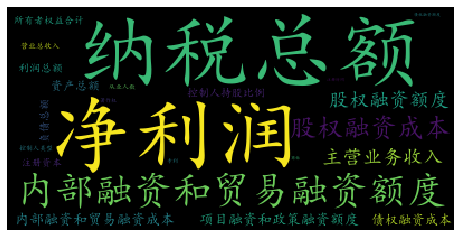

In [58]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image


image = Image.open('./data/created_data/timg.jfif')  # 作为背景轮廓图
graph = np.array(image)
# 参数分别是指定字体、背景颜色、最大的词的大小、使用给定图作为背景形状
wc = WordCloud(font_path='simkai.ttf', background_color='black', max_words=2000, mask=graph) #, mask=graph
wc.generate_from_frequencies(dic)  # 根据给定词频生成词云
image_color = ImageColorGenerator(graph)
plt.imshow(wc)
plt.axis("off")  # 不显示坐标轴
plt.show()
wc.to_file('./data/created_data/wordcloud.png')  # 图片命名


In [65]:
# ?WordCloud
aaaa=[i for i in list(net.state_dict()['fc.weight'].cpu().numpy()[1])]

In [66]:
di=dict(zip(features, aaaa))

In [67]:
di

{'专利': 0.082955696,
 '主营业务收入': -2.1722279,
 '从业人数': -0.10625844,
 '企业类型': -0.014821291,
 '债权融资成本': -0.6761063,
 '债权融资额度': -0.04763195,
 '内部融资和贸易融资成本': 0.8719811,
 '内部融资和贸易融资额度': -6.008491,
 '净利润': -65.08771,
 '利润总额': -0.4041719,
 '区域': -0.014687048,
 '商标': 0.056810427,
 '所有者权益合计': 0.32814398,
 '控制人持股比例': -0.36780196,
 '控制人类型': -0.11797286,
 '注册时间': -0.043270275,
 '注册资本': 0.3131379,
 '纳税总额': -70.349525,
 '股权融资成本': -4.6301885,
 '股权融资额度': -2.138371,
 '营业总收入': -0.15740019,
 '著作权': -0.0765183,
 '行业': 0.031455807,
 '负债总额': -0.38085914,
 '资产总额': 0.5552981,
 '项目融资和政策融资成本': -0.001372852,
 '项目融资和政策融资额度': -0.93254226}